## POS tagging using modified Viterbi

### Objective

- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 

- Solve the problem of unknown words using at least two techniques. 

- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.

- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after our modifications.

In [1]:
## Importing libraries
import nltk
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
## nltk.download('universal_tagset')

### 01. Data Preparation

In [2]:
## nltk.download('treebank')

#### Reading the Treebank tagged sentences

In [3]:
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
type(nltk_data)

list

#### Tagged sentences

In [4]:
print(nltk_data[::])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

#### POS tags

In [5]:
tags=[x[0][1] for x in nltk_data]
print(tags)

['NOUN', 'NOUN', 'NOUN', 'DET', 'DET', 'NOUN', 'ADP', 'DET', 'PRON', 'DET', 'DET', '.', 'NOUN', 'DET', 'ADP', 'ADP', 'NUM', 'DET', '.', 'DET', 'DET', 'DET', 'DET', 'ADV', 'ADP', 'ADP', 'ADP', 'NOUN', 'NOUN', 'NOUN', '.', '.', 'PRON', 'NOUN', 'DET', 'NOUN', 'ADJ', 'ADJ', 'ADJ', 'DET', 'ADV', 'DET', 'ADP', 'NOUN', 'ADV', 'DET', 'NOUN', 'PRON', 'DET', 'DET', 'NOUN', 'PRON', 'NOUN', 'NOUN', 'DET', 'NOUN', 'NOUN', 'NOUN', 'PRON', 'DET', 'ADP', 'DET', 'NOUN', 'DET', 'DET', 'NOUN', 'ADP', 'ADV', 'PRON', 'ADV', 'ADV', 'DET', 'CONJ', 'DET', 'ADP', 'ADP', 'NOUN', 'DET', 'DET', 'DET', 'ADV', 'ADP', 'X', 'ADV', 'DET', 'ADP', 'X', 'ADJ', 'CONJ', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'ADP', 'NOUN', 'NOUN', 'DET', 'NOUN', 'NOUN', 'DET', 'ADP', 'NOUN', 'NOUN', 'DET', 'NOUN', '.', 'DET', 'ADV', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.', 'DET', 'NOUN', 'DET', '.', 'PRON', 'NOUN', 'DET', '.', 'ADV', 'NOUN', 'NOUN', 'NOUN', 'PRON', 'NOUN', 'DET', 'NOUN', 'NOUN', '.

In [6]:
## Further checking for the distinct tags
unique_tags = set(tags)
print(list(unique_tags))

['ADP', 'PRON', 'PRT', 'ADV', '.', 'DET', 'NOUN', 'ADJ', 'CONJ', 'VERB', 'X', 'NUM']


#### Splitting into train and test

In [7]:
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)


In [8]:
## Summary of the train and test dataset
print("Training Set Length -", len(train_set))
print("Training Set Length -", len(test_set))
print("Training Data at a glance -\n")
print(train_set[:15])

Training Set Length - 3718
Training Set Length - 196
Training Data at a glance -

[[('--', '.'), ('Pat', 'NOUN'), ("D'Amico", 'NOUN'), ('.', '.')], [('Many', 'ADJ'), ('grain', 'NOUN'), ('processors', 'NOUN'), ('and', 'CONJ'), ('exporters', 'NOUN'), ('use', 'VERB'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('corn', 'NOUN'), ('futures', 'NOUN'), ('contracts', 'NOUN'), ('traded', 'VERB'), ('*', 'X'), ('there', 'ADV'), ('*-1', 'X'), ('to', 'PRT'), ('calculate', 'VERB'), ('the', 'DET'), ('price', 'NOUN'), ('0', 'X'), ('they', 'PRON'), ('offer', 'VERB'), ('*T*-2', 'X'), ('*-3', 'X'), ('to', 'PRT'), ('buy', 'VERB'), ('corn', 'NOUN'), ('from', 'ADP'), ('farmers', 'NOUN'), ('.', '.')], [('LONDON', 'NOUN'), ('INTERBANK', 'NOUN'), ('OFFERED', 'VERB'), ('RATES', 'NOUN'), ('-LRB-', '.'), ('LIBOR', 'NOUN'), ('-RRB-', '.'), (':', '.'), ('8', 'NUM'), ('3\\/4', 'NUM'), ('%', 'NOUN'), ('one', 'NUM'), ('month', 'NOUN'), (';', '.'), ('8', 'NUM'), ('3\\/4', 'NUM'), ('%', 'NOUN'), (

#### Getting list of tagged words

In [9]:
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95536

In [10]:
## Let's have a look at the tagged words in the training set
train_tagged_words[:10]

[('--', '.'),
 ('Pat', 'NOUN'),
 ("D'Amico", 'NOUN'),
 ('.', '.'),
 ('Many', 'ADJ'),
 ('grain', 'NOUN'),
 ('processors', 'NOUN'),
 ('and', 'CONJ'),
 ('exporters', 'NOUN'),
 ('use', 'VERB')]

In [11]:
## tokens in the train set - train_tagged_words
train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tokens[:10]

['--',
 'Pat',
 "D'Amico",
 '.',
 'Many',
 'grain',
 'processors',
 'and',
 'exporters',
 'use']

In [12]:
## POS tags for the tokens in the train set -
train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['.', 'NOUN', 'NOUN', '.', 'ADJ', 'NOUN', 'NOUN', 'CONJ', 'NOUN', 'VERB']

In [13]:
## building the train vocabulary to a set
training_vocabulary_set = set(train_data_tokens)

In [14]:
## building the POS tags to a set
training_pos_tag_set = set(train_data_pos_tags)

#### Summary

In [15]:

print("Length : \nVocabulary: {} \nTags: {}".format(len(training_vocabulary_set), len(training_pos_tag_set)))
print("\nAvailable Tags :\n")
print(training_pos_tag_set)

Length : 
Vocabulary: 12091 
Tags: 12

Available Tags :

{'ADP', 'PRON', 'PRT', 'ADV', '.', 'DET', 'ADJ', 'NOUN', 'VERB', 'CONJ', 'X', 'NUM'}


## 02. Emission Probabilities

**computing P(w/t) and storing in [Tags x Vocabulary] matrix. This is a matrix with dimension of len(training_pos_tag_set) X en(training_vocabulary_set)**

In [16]:
len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

word_given_tag = np.zeros((len_pos_tags, len_vocab))

In [17]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

## 03. Transition Probabilities

**compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability**

In [18]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [19]:
# steps-
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# Let's have a look into the transition matrix
tags_matrix

array([[1.68569293e-02, 7.00949505e-02, 1.49365200e-03, 1.30161103e-02,
        4.01152261e-02, 3.23802412e-01, 1.05622530e-01, 3.23162287e-01,
        8.64184368e-03, 7.46826001e-04, 3.45673747e-02, 6.18798696e-02],
       [2.33626962e-02, 8.04289524e-03, 1.30218305e-02, 3.40865552e-02,
        4.17464562e-02, 9.95787047e-03, 7.46840313e-02, 2.07200304e-01,
        4.84105706e-01, 4.59594047e-03, 9.15358067e-02, 7.65990047e-03],
       [2.02086046e-02, 1.82529334e-02, 1.95567147e-03, 9.12646670e-03,
        4.23728824e-02, 1.01043023e-01, 8.67014378e-02, 2.49022171e-01,
        3.98305088e-01, 2.28161667e-03, 1.36897005e-02, 5.70404157e-02],
       [1.19253829e-01, 1.46568958e-02, 1.43237840e-02, 8.09460357e-02,
        1.34910062e-01, 6.92871436e-02, 1.28914058e-01, 3.13124582e-02,
        3.43770832e-01, 7.66155915e-03, 2.36508995e-02, 3.13124582e-02],
       [9.10810828e-02, 6.51351362e-02, 2.34234240e-03, 5.25225215e-02,
        9.34234262e-02, 1.73873872e-01, 4.36936952e-02, 2.23

In [20]:
# convert the matrix to a data frame for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

# Let's have a look at the dataset
tags_df

ADP      PRON       PRT       ADV         .       DET       ADJ  \
ADP   0.016857  0.070095  0.001494  0.013016  0.040115  0.323802  0.105623   
PRON  0.023363  0.008043  0.013022  0.034087  0.041746  0.009958  0.074684   
PRT   0.020209  0.018253  0.001956  0.009126  0.042373  0.101043  0.086701   
ADV   0.119254  0.014657  0.014324  0.080946  0.134910  0.069287  0.128914   
.     0.091081  0.065135  0.002342  0.052523  0.093423  0.173874  0.043694   
DET   0.009292  0.003741  0.000241  0.012308  0.017135  0.005430  0.204175   
ADJ   0.077228  0.000496  0.011080  0.004465  0.065983  0.004796  0.065652   
NOUN  0.177213  0.004595  0.044166  0.017141  0.239104  0.013348  0.012145   
VERB  0.092683  0.036000  0.031568  0.081875  0.035223  0.134204  0.065158   
CONJ  0.052827  0.059778  0.005097  0.053290  0.034291  0.120019  0.117238   
X     0.143611  0.056453  0.184871  0.025588  0.163282  0.054694  0.015992   
NUM   0.034555  0.001489  0.027405  0.002979  0.118260  0.003277  0.033065   

          NOUN      VERB      CONJ         X       NUM  
ADP   0.323162  0.008642  0.000747  0.034567  0.061880  
PRON  0.207200  0.484106  0.004596  0.091536  0.007660  
PRT   0.249022  0.398305  0.002282  0.013690  0.057040  
ADV   0.031312  0.343771  0.007662  0.023651  0.031312  
.     0.223243  0.088198  0.058108  0.027297  0.080991  
DET   0.639315  0.039821  0.000483  0.045976  0.022083  
ADJ   0.700843  0.011576  0.017033  0.020506  0.020341  
NOUN  0.263540  0.146978  0.042890  0.029323  0.009555  
VERB  0.110567  0.168261  0.005443  0.215924  0.023093  
CONJ  0.350788  0.155236  0.000463  0.008341  0.042632  
X     0.061890  0.206781  0.010235  0.073885  0.002719  
NUM   0.352994  0.018171  0.013703  0.210903  0.183199

In [21]:
tags_df.loc['.', :]

ADP     0.091081
PRON    0.065135
PRT     0.002342
ADV     0.052523
.       0.093423
DET     0.173874
ADJ     0.043694
NOUN    0.223243
VERB    0.088198
CONJ    0.058108
X       0.027297
NUM     0.080991
Name: ., dtype: float32

## 04. Exploratory Data Analysis

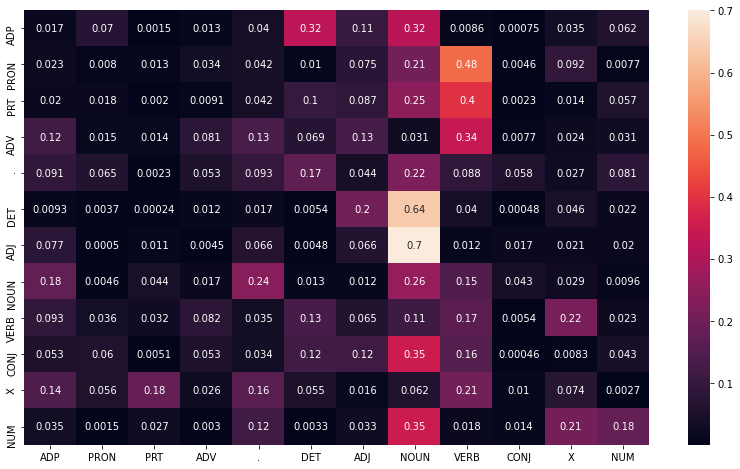

In [22]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

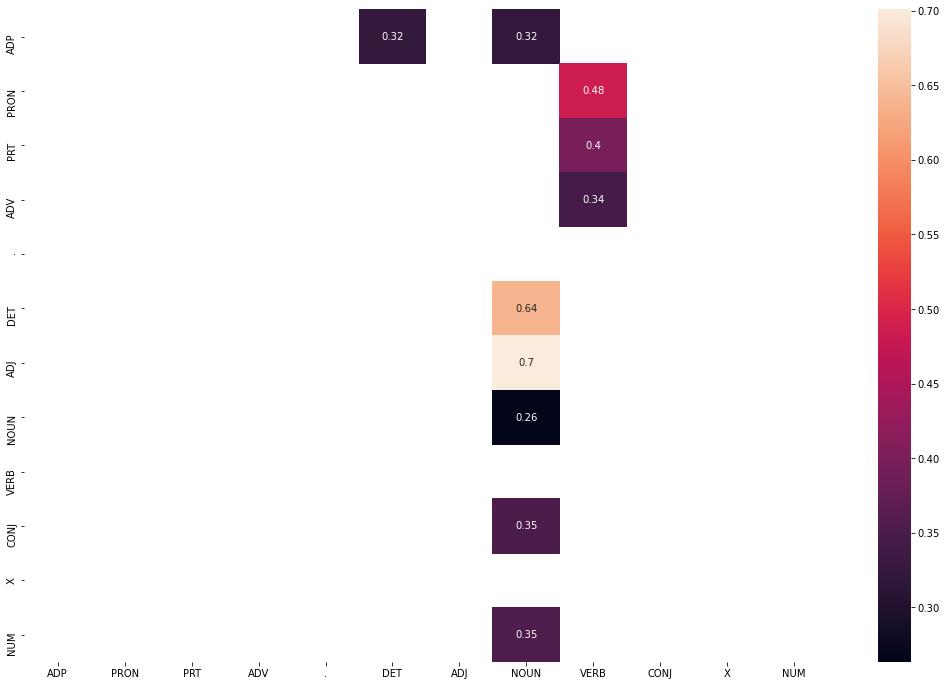

In [23]:
# frequent tags
# filter the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent,annot=True)
plt.show()

In [24]:
len(train_tagged_words)

95536

## 05. Build the vanilla Viterbi based POS tagger

#### Viterbi Heuristic

In [25]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [26]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('We', 'PRON'),
  ('are', 'VERB'),
  ('prepared', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('pursue', 'VERB'),
  ('aggressively', 'ADV'),
  ('completion', 'NOUN'),
  ('of', 'ADP'),
  ('this', 'DET'),
  ('transaction', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('he', 'PRON'),
  ('says', 'VERB'),
  ('*T*-2', 'X'),
  ('.', '.')],
 [('Texaco', 'NOUN'),
  ('rose', 'VERB'),
  ('3\\/4', 'NUM'),
  ('to', 'PRT'),
  ('53', 'NUM'),
  ('3\\/8', 'NUM'),
  ('as', 'ADP'),
  ('4.4', 'NUM'),
  ('million', 'NUM'),
  ('shares', 'NOUN'),
  ('changed', 'VERB'),
  ('hands', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('We', 'PRON'),
  ("'re", 'VERB'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('very', 'ADV'),
  ('different', 'ADJ'),
  ('regulatory', 'ADJ'),
  ('environment', 'NOUN'),
  ('.', '.'),
  ("''", '.')],
 [('In', 'ADP'),
  ('an', 'DET'),
  ('era', 'NOUN'),
  ('when', 'ADV'),
  ('every', 'DET'),
  ('government', 'NOUN'),
  ('agency', 'NOUN'),
  ('has', 'VERB'),
  ('a', 'DET'),
  ('public-rel

In [27]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  54.50015926361084
[('``', '.'), ('We', 'PRON'), ('are', 'VERB'), ('prepared', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('pursue', 'VERB'), ('aggressively', 'ADV'), ('completion', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('transaction', 'NOUN'), (',', '.'), ("''", '.'), ('he', 'PRON'), ('says', 'VERB'), ('*T*-2', 'X'), ('.', '.'), ('Texaco', 'NOUN'), ('rose', 'VERB'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('53', 'NUM'), ('3\\/8', 'NUM'), ('as', 'ADP'), ('4.4', 'NUM'), ('million', 'NUM'), ('shares', 'NOUN'), ('changed', 'VERB'), ('hands', 'NOUN'), ('.', '.'), ('``', '.'), ('We', 'PRON'), ("'re", 'VERB'), ('in', 'ADP'), ('a', 'DET'), ('very', 'ADV'), ('different', 'ADJ'), ('regulatory', 'ADJ'), ('environment', 'NOUN'), ('.', '.'), ("''", '.'), ('In', 'ADP'), ('an', 'DET'), ('era', 'NOUN'), ('when', 'ADV'), ('every', 'DET'), ('government', 'NOUN'), ('agency', 'NOUN'), ('has', 'VERB'), ('a', 'DET'), ('public-relations', 'ADP'), ('machine', 'NOUN'), ('that', 'ADP'), ('*T*-2',

In [28]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vannila_viterbi_accuracy = len(check)/len(tagged_seq)
vannila_viterbi_accuracy

print("The accuracy of the Vanilla Viterbi Algorithm is -", vannila_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is - 0.9316239316239316


In [29]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

8


[[('a', 'DET'), (('public-relations', 'ADP'), ('public-relations', 'NOUN'))],
 [('machine', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*T*-2', 'X'), (('sends', 'ADP'), ('sends', 'VERB'))],
 [('you', 'PRON'), (('stuff', 'ADP'), ('stuff', 'NOUN'))],
 [("'s", 'VERB'), (('rare', 'ADP'), ('rare', 'ADJ'))],
 [('rare', 'ADJ'), (('that', 'DET'), ('that', 'ADP'))],
 [('name', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('James', 'NOUN'), (('Ednie', 'ADP'), ('Ednie', 'NOUN'))]]

In [30]:
## nltk.download('punkt')
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start


In [31]:
print(tagged_seq)

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.'), ('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.'), ('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose', 'ADP'), ('.', '.'), ('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'ADP'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN

In [32]:
print(difference)
vannila_test_tagged_seq = tagged_seq

89.43419146537781


In [33]:
# Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 5


Unknown Words : ['public-relations', 'rare', 'Ednie', 'stuff', 'sends']


### Solve the problem of unknown words

#### Version 1 : Rule Based Tagging with Viterbi

In [34]:
pattern = [
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*es$', 'VERB'), 
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), # default value as NOUN
]

def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]


In [35]:
# Viterbi Heuristic
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

public-relations
NOUN
sends
NOUN
stuff
NOUN
rare
NOUN
Ednie
NOUN
Time taken in seconds:  55.00708270072937
[('``', '.'), ('We', 'PRON'), ('are', 'VERB'), ('prepared', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('pursue', 'VERB'), ('aggressively', 'ADV'), ('completion', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('transaction', 'NOUN'), (',', '.'), ("''", '.'), ('he', 'PRON'), ('says', 'VERB'), ('*T*-2', 'X'), ('.', '.'), ('Texaco', 'NOUN'), ('rose', 'VERB'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('53', 'NUM'), ('3\\/8', 'NUM'), ('as', 'ADP'), ('4.4', 'NUM'), ('million', 'NUM'), ('shares', 'NOUN'), ('changed', 'VERB'), ('hands', 'NOUN'), ('.', '.'), ('``', '.'), ('We', 'PRON'), ("'re", 'VERB'), ('in', 'ADP'), ('a', 'DET'), ('very', 'ADV'), ('different', 'ADJ'), ('regulatory', 'ADJ'), ('environment', 'NOUN'), ('.', '.'), ("''", '.'), ('In', 'ADP'), ('an', 'DET'), ('era', 'NOUN'), ('when', 'ADV'), ('every', 'DET'), ('government', 'NOUN'), ('agency', 'NOUN'), ('has', 'VERB'), ('a', 'DET'), ('public-re

In [36]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.9658119658119658


In [37]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('machine', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*T*-2', 'X'), (('sends', 'NOUN'), ('sends', 'VERB'))],
 [("'s", 'VERB'), (('rare', 'NOUN'), ('rare', 'ADJ'))],
 [('name', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))]]

In [38]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
rulebased_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
networking
VERB
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter',

#### Version 2 : Lexicon Based Tagging with Viterbi

In [39]:

def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [40]:
# Viterbi Heuristic
def modified_Viterbi_lexicon_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

public-relations
NOUN
sends
NOUN
stuff
NOUN
rare
NOUN
Ednie
NOUN
Time taken in seconds:  51.24845600128174
[('``', '.'), ('We', 'PRON'), ('are', 'VERB'), ('prepared', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('pursue', 'VERB'), ('aggressively', 'ADV'), ('completion', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('transaction', 'NOUN'), (',', '.'), ("''", '.'), ('he', 'PRON'), ('says', 'VERB'), ('*T*-2', 'X'), ('.', '.'), ('Texaco', 'NOUN'), ('rose', 'VERB'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('53', 'NUM'), ('3\\/8', 'NUM'), ('as', 'ADP'), ('4.4', 'NUM'), ('million', 'NUM'), ('shares', 'NOUN'), ('changed', 'VERB'), ('hands', 'NOUN'), ('.', '.'), ('``', '.'), ('We', 'PRON'), ("'re", 'VERB'), ('in', 'ADP'), ('a', 'DET'), ('very', 'ADV'), ('different', 'ADJ'), ('regulatory', 'ADJ'), ('environment', 'NOUN'), ('.', '.'), ("''", '.'), ('In', 'ADP'), ('an', 'DET'), ('era', 'NOUN'), ('when', 'ADV'), ('every', 'DET'), ('government', 'NOUN'), ('agency', 'NOUN'), ('has', 'VERB'), ('a', 'DET'), ('public-re

In [41]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9658119658119658


[[('machine', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*T*-2', 'X'), (('sends', 'NOUN'), ('sends', 'VERB'))],
 [("'s", 'VERB'), (('rare', 'NOUN'), ('rare', 'ADJ'))],
 [('name', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))]]

In [42]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
networking
VERB
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter',

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [43]:
print("Vannila Viterbi Accuracy: "+ str(vannila_viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy))

Vannila Viterbi Accuracy: 0.9316239316239316
Lexicon Based Viterbi Accuracy: 0.9658119658119658
Rule Based Viterbi Accuracy: 0.9658119658119658


In [44]:
## Let's visualize the 

acccuracy_on_sample_test_data = [['Vanilla Viterbi', vannila_viterbi_accuracy*100], 
                  ['Lexicon Based Viterbi', lexicon_based_viterbi_accuracy*100], 
                  ['Rule Based Viterbi', rulebased_modified_viterbi_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

Tagging_Accuracy
Tagging_Algorithm                      
Vanilla Viterbi               93.162393
Lexicon Based Viterbi         96.581197
Rule Based Viterbi            96.581197

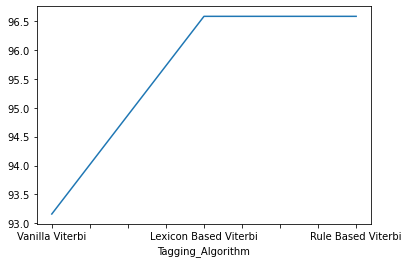

In [45]:
sample_test_data_acccuracy_df.plot.line(rot = 0, legend = False)
plt.show()

#### Observation:  Lexicon Based Viterbi & Rule Based Viterbi 's accuracy are greater than Plain Vannila Viterbi's accuracy

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [46]:
# A dataframe showing - 
# 1. words as tagged by vanilla viterbi
# 2. words as tagged by viterbi_for_rule_based - METHOD - 1
# 3. words as tagged by viterbi_for_lexicon_based - METHOD - 2

cols1 = ['as_tagged_by_vanilla_viterbi', 'as_tagged_by_Viterbi_rule_Based',
            'as_tagged_by_Viterbi_Lexicon_Based']

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)


# tags by vanilla viterbi
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in vannila_test_tagged_seq]

# tags by Vanilla_Viterbi_for_Rule_Based - METHOD - 1
tags_comparison_df.as_tagged_by_Viterbi_rule_Based= [tup for tup in rulebased_test_tagged_seq]

# tags by Vanilla_Viterbi_for_Lexicon_Based  - METHOD - 2
tags_comparison_df.as_tagged_by_Viterbi_Lexicon_Based = [tup for tup in 
                                                                            lexicon_test_tagged_seq]

tags_comparison_df[tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Viterbi_Lexicon_Based]

as_tagged_by_vanilla_viterbi as_tagged_by_Viterbi_rule_Based  \
0                 (Android, ADP)                 (Android, NOUN)   
8                  (Google, ADP)                  (Google, NOUN)   
10                (Android, ADP)                 (Android, NOUN)   
15                     (OS, ADP)                      (OS, NOUN)   
16              (worldwide, ADP)               (worldwide, NOUN)   
18            (smartphones, ADP)             (smartphones, VERB)   
20                   (2011, ADP)                     (2011, NUM)   
25                   (2013, ADP)                     (2013, NUM)   
27                 (Google, ADP)                  (Google, NOUN)   
29                (Twitter, ADP)                 (Twitter, NOUN)   
34                   (2015, ADP)                     (2015, NUM)   
35                   (that, DET)                     (that, ADP)   
37                 (Google, ADP)                  (Google, NOUN)   
40                (Twitter, ADP)                 (Twitter, NOUN)   
42               (firehose, ADP)                (firehose, NOUN)   
44                (Twitter, ADP)                 (Twitter, NOUN)   
47                 (online, ADP)                  (online, NOUN)   
51             (networking, ADP)              (networking, VERB)   
58               (interact, ADP)                (interact, NOUN)   
60               (messages, ADP)                (messages, VERB)   
61                  (known, ADJ)                   (known, VERB)   
63                 (tweets, ADP)                  (tweets, NOUN)   
73            (domineering, ADP)             (domineering, VERB)   
78            (personality, ADP)             (personality, NOUN)   
81                   (2018, ADP)                     (2018, NUM)   
82                   (FIFA, ADP)                    (FIFA, NOUN)   
84                    (Cup, ADP)                     (Cup, NOUN)   
87                   (21st, ADP)                     (21st, NUM)   
88                   (FIFA, ADP)                    (FIFA, NOUN)   
90                    (Cup, ADP)                     (Cup, NOUN)   
95             (tournament, ADP)              (tournament, NOUN)   
96              (contested, ADP)               (contested, VERB)   
107                   (Cup, ADP)                     (Cup, NOUN)   
131                 (trips, ADP)                   (trips, NOUN)   
163              (arriving, ADP)                (arriving, VERB)   
168                  (NASA, ADP)                    (NASA, NOUN)   
169               (invited, ADP)                 (invited, VERB)   
178              (ICESAT-2, ADP)                (ICESAT-2, NOUN)   
179             (Satellite, ADP)               (Satellite, NOUN)   

    as_tagged_by_Viterbi_Lexicon_Based  
0                      (Android, NOUN)  
8                       (Google, NOUN)  
10                     (Android, NOUN)  
15                          (OS, NOUN)  
16                   (worldwide, NOUN)  
18                 (smartphones, VERB)  
20                         (2011, NUM)  
25                         (2013, NUM)  
27                      (Google, NOUN)  
29                     (Twitter, NOUN)  
34                         (2015, NUM)  
35                         (that, ADP)  
37                      (Google, NOUN)  
40                     (Twitter, NOUN)  
42                    (firehose, NOUN)  
44                     (Twitter, NOUN)  
47                      (online, NOUN)  
51                  (networking, VERB)  
58                    (interact, NOUN)  
60                    (messages, VERB)  
61                       (known, VERB)  
63                      (tweets, NOUN)  
73                 (domineering, VERB)  
78                 (personality, NOUN)  
81                         (2018, NUM)  
82                        (FIFA, NOUN)  
84                         (Cup, NOUN)  
87                         (21st, NUM)  
88                        (FIFA, NOUN)  
90                         (Cup, NOUN)  
95          

#### Observations:

- Words like 'Twitter', 'Android', 'Google' are properly tagged with 'NOUN' in modified Viterbi Algorithm
- Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' (All Caps of a word generally will be an abbrevation and it is a noun)
- Words ending with '-ing' like 'arriving' and words ending with '-ed' like 'invited' are properly tagged as 'VERB' in Rule Based Tagging
- Words with integers or float are properly tagged as 'NUM' are properly tagged as NUM in rule based tagger
- In Lexicon tagger, words are tagged as 'NOUN' by default in the default tagger if any of the taggers cannot able to tag them. And it corrects most of the unknown words like 'Google', 'Android', 'Twitter' etc.

